## Final Project:
### Stephen Phillips





## Abstract:

The first motion picture ever created was in 1878, titled "The Horse in Motion", it was made in an attempt to prove whether or not horses galloped with all four hooves off of the ground. Since then, cinema has developed into an important platform for entertainment, expression, and thought provocation. My project has taken all data from IMDB on movies and actors and attempted to identify trends in movies and actors over the years using SQL and python. I believe that this is relevant to film producers, directors, and studios as it can aid in producing a profitable motion picture. By looking at trends, we can identify what elements of movies are popular, which are becoming popular, and which are losing favor with the general public. After analyzing data gathered by IMDB, various conclusions about motion pictures could be made. The average length of movies has grown over the years. The shortness of movies was initially due to technological limitations, but a change in preferences of consumers forced movies to become longer. Recently, technology has allowed for easier production of cinematic pieces, causing a huge influx in motion pictures since the 2000's. Other conclusions are that motion picture reviewers have given higher average ratings as time has passed, before plateuing in the mid 1920s. The most popular type of motion pictures in production historically have been comedies and dramas. If film producers are looking to produce a movie that will on average be rated highly, they should work on a documentary or something historical. If they want to create something that has high "engagement" then the optimal choices are a sci-fi, thriller, or biographical piece. The most volatile movie that a producer can make is a horror film. If a producer is looking for a specific medium to work on, television shows tend to have higher ratings than movies will. 

## Introduction:

My practical goals with this project was to successfully create a database using a large data set and analyze it using the tools that we have gained this semester. As my data set is the entirety of public data available from IMDB, I will be looking for underlying trends in movies/shows.More specifically, my goal is to look at trends over time with motion pictures, and interesting demographic information, such as most popular genres and actors. While I would like to use this data to help potential film maker/actors make more informed decisions about the motion pictures they choose to create, I will be satisfied by simply identifying cool trends/information. The data that I analyzed was collected from: https://developer.imdb.com/non-commercial-datasets/. Unfortunately, I don't have access to financial data about the motion pictures included in this dataset. After my analyis, I hope to identify future directions in which analyis could head towards. 

## Data Wrangling/ EDA:

As the data wrangling and EDA are done together, I have decided to combine this section. Since data was placed into a mySQL database before it was analyzed, much of the data wrangling was done in SQL. This required taking the raw data files and inserting them into mySQL, as well as creating a relational database. After creating a relational database, views were created that combined certain information from tables together. Other manipulations done with mySQL include shifting a table into a longer format so that it could be analyzed easier. The SQL Queries for this can be seen below:

Now for the rest of the data wrangling, the data must be queried and placed into a dataframe. Below are the packages that are used to in my analysis:

In [311]:
import mysql.connector
from mysql.connector.plugins import caching_sha2_password
from getpass import getpass
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from collections import Counter


Query Our Server:

In [312]:
## We can load the imdb database from our SQL Server.The database names are "names", "title_basic", "title_crew", "title_episode", "title_ratings"
mydb  = mysql.connector.connect(
    host = "localhost",
     auth_plugin = "mysql_native_password",
    user = "root",
    database = "imdb",
    passwd = getpass()
)

print(mydb)

In [313]:
mycursor = mydb.cursor()

We will select the "full_movies" view that combines two tables of motion picture information

In [314]:
sql = """
SELECT * 
FROM imdb.full_movies
"""

In [315]:
mycursor.execute(sql)
myresult = mycursor.fetchall()
field_names = [i[0] for i in mycursor.description]

In [316]:
df = pd.DataFrame(myresult)
df.columns = field_names
df.head()


,titleID,type,primary_title,is_adult,start_year,end_year,run_time,genres,rating,num_votes
0,tt0000001,short,Carmencita,0,1894.0,NaN,1.0,"Documentary,Short",5.7,2041
1,tt0000002,short,Le clown et ses chiens,0,1892.0,NaN,5.0,"Animation,Short",5.7,273
2,tt0000003,short,Pauvre Pierrot,0,1892.0,NaN,4.0,"Animation,Comedy,Romance",6.5,1997
3,tt0000004,short,Un bon bock,0,1892.0,NaN,12.0,"Animation,Short",5.4,178
4,tt0000005,short,Blacksmith Scene,0,1893.0,NaN,1.0,"Comedy,Short",6.2,2757


In [317]:
df.shape

(1424444, 10)

There are 10 columns and about 1,420,000

We can look at the missing values in each column:



In [318]:
df.isnull().sum(axis = 0)

titleID                0
type                   0
primary_title          0
is_adult               0
start_year           238
end_year         1371142
run_time          417060
genres             20466
rating                 0
num_votes              0
dtype: int64

It looks as though there are missing values only in the columns: start_year,end_year, run_time, and genres. We will not be trying to impute the missing data, we will simply leave it as is, or remove it if it hinders analysis. Because we will need a data frame for the actors as well, we will query this too:

In [319]:
sql = """
SELECT * 
FROM imdb.actor_movies
"""

In [320]:
mycursor.execute(sql)
myresult = mycursor.fetchall()
field_names = [i[0] for i in mycursor.description]

In [321]:
df2 = pd.DataFrame(myresult)
df2.columns = field_names
df2.head()


,nameID,name,profession,movie_id
0,nm0000001,Fred Astaire,"actor,miscellaneous,producer",tt0072308
1,nm0000002,Lauren Bacall,"actress,soundtrack,archive_footage",tt0037382
2,nm0000003,Brigitte Bardot,"actress,music_department,producer",tt0057345
3,nm0000004,John Belushi,"actor,writer,music_department",tt0072562
4,nm0000005,Ingmar Bergman,"writer,director,actor",tt0050986


In [322]:
df2.shape

(23508654, 4)

We have 4 columns and about 23,500,000 values.

In [323]:
df2.isnull().sum(axis = 0)

nameID              0
name           277154
profession    2662923
movie_id      1472425
dtype: int64

For this, we have many values that are missing from our data in the name, profession, and movie_id column. We should consider dropping the columns that don't contain a name.

## Data Analysis:



### Cinema Over Time:
We can group our motion pictures by year and look at how the average stats have changed over the years:

In [324]:
result = df.groupby(by = ["start_year"])[["rating","run_time", "num_votes"]].mean()
result = result.reset_index()
result.columns = ["year", "rating", "run_time", "num_votes"]
result["year"] = result["year"].astype(int)
result["num_votes"] = result["num_votes"].astype(int)
result

,year,rating,run_time,num_votes
0,1874,6.800000,1.000000,2067
1,1877,5.475000,1.000000,192
2,1878,6.200000,1.000000,1370
3,1881,5.600000,1.000000,405
4,1882,5.650000,1.000000,255
...,...,...,...,...
141,2021,7.125528,56.249040,756
142,2022,7.220862,60.472735,771
143,2023,7.299014,63.614602,637
144,2024,7.491793,66.944960,368


Now we can plot how the average rating of movies has trended historically:

In [325]:
fig = px.line(result, x = "year", y = "rating", title = "Motion Picture Average Rating as Time passes")
fig.show()

There is definitely a trend in the average ratings of shows/movies as time has passed. It seems as though people from 1880-1900 were harsher critics or interpreted 5/10 ratings as being the true "average" while nowadays a 5/10 would be something that most people wouldnt watch. Now we can see how runtime has been impacted over time. 

In [326]:
fig = px.line(result, x = "year", y = "run_time", title ="Motion Picture Average Length as Time Passes")
fig.show()

From the 1880s to the mid 1910's, most cinema was under 10 minutes. I did a little bit of research to determine the cause of this. 1 reel of film in the early days of cinema was about 15 minutes of recording. Going to a movie theatre meant watching several films, all around 15 minutes long, rather than one long cinematic piece. The increase in film length in Europe was largely because of Italian film "Quo Vadis", a story about the Roman Empire in the time of Nero which spanned 2 hours. In 1915 the American film maker D.W. Griffith released the movie "The Birth of a Nation", which was 193 minutes long (12 film reels) and full of stunts and battle scenes that drew the American public to it. After this, the perception of movies shifted and we began to see much longer standalone films. More information on this topic can be found at: https://www.youtube.com/watch?v=stznrpS3_Gc

In [327]:
df[df["primary_title"] == "Quo Vadis?"]

,titleID,type,primary_title,is_adult,start_year,end_year,run_time,genres,rating,num_votes
1112,tt0002445,movie,Quo Vadis?,0,1913.0,NaN,120.0,"Drama,History",6.1,438
4395,tt0015253,movie,Quo Vadis?,0,1924.0,NaN,90.0,Drama,5.9,102
65250,tt0089870,tvMiniSeries,Quo Vadis?,0,1985.0,1985.0,360.0,Drama,6.5,332
154866,tt0247646,short,Quo Vadis?,0,1901.0,NaN,1.0,Short,5.8,24
276128,tt0519082,tvEpisode,Quo Vadis?,0,1978.0,NaN,30.0,"Comedy,Drama",8.0,123
299469,tt0568076,tvEpisode,Quo Vadis?,0,2001.0,NaN,45.0,"Drama,Romance",7.5,338
1010058,tt28085515,short,Quo Vadis?,0,2023.0,NaN,27.0,"Drama,Short",9.0,10
1310762,tt7197374,tvEpisode,Quo Vadis?,0,2017.0,NaN,NaN,"Action,Adventure,Drama",6.7,10


In [328]:
df[df["primary_title"] == "The Birth of a Nation"]

,titleID,type,primary_title,is_adult,start_year,end_year,run_time,genres,rating,num_votes
1646,tt0004972,movie,The Birth of a Nation,0,1915.0,NaN,195.0,"Drama,History,War",6.1,26305
48150,tt0070094,movie,The Birth of a Nation,0,1973.0,NaN,70.0,None,7.1,25
1132366,tt4196450,movie,The Birth of a Nation,0,2016.0,NaN,120.0,"Biography,Drama,History",6.5,21810


In [329]:
fig = px.line(result, x = "year", y = "num_votes", title = "Average Number of Motion Picture Votes as Time passes")
fig.show()

The average number of motion picture votes has flutuated historically. From 1919 to 2000, the average ratings were on a slow incline, but from there onwards it seems that the average motion picture doesn't have as many reviews. There are a couple things that could explain this. It is far easier to make a film today than it has been in the past, thanks to high quality phone recordings. It is possible that IMDB is more saturated with indie films today that do not recieve reviews, bringing the average down.

In [330]:
year_counts = df.groupby(by = ["start_year"])[["rating","run_time", "num_votes"]].size()

In [331]:
fig = px.line(year_counts,  title = "Count of Yearly Motion Pictures Produced")
fig.update_layout(showlegend =False)
fig.show()

As expected, the trend of motion pictures being produced has skyrocketed around the time that our average number of votes has fallen. Although I have no concrete evidence, I can confidently say that smartphones have lowered the barrier to motion picture production, increasing the influx of IMDB entries and lowering average amount of votes on IMDB entries.

In [332]:
result = df.groupby(by = "start_year")[["rating","run_time", "num_votes","titleID","primary_title"]].max()
result = result.reset_index()
result.columns = ["year", "rating", "run_time", "num_votes", "titleID","title"]
result["year"] = result["year"].astype(int)
result["num_votes"] = result["num_votes"].astype(int)
result

,year,rating,run_time,num_votes,titleID,title
0,1874,6.8,1.0,2067,tt3155794,Passage de Venus
1,1877,5.8,1.0,320,tt16763774,The Tight-rope Dance
2,1878,7.4,1.0,3659,tt27119262,Sallie Gardner at a Gallop
3,1881,6.1,1.0,563,tt7816420,Skeleton of Horse
4,1882,6.2,1.0,333,tt16263734,The Kiss
...,...,...,...,...,...,...
141,2021,10.0,3000.0,875357,tt9914972,Überwachen und belohnen
142,2022,10.0,2252.0,783785,tt9916128,Üçgen
143,2023,10.0,11541.0,711261,tt9900816,【Oshi No Ko】
144,2024,10.0,385.0,322051,tt9859436,Þáttur 1


In [333]:
filter_index = df.groupby("start_year")["num_votes"].idxmax()
filter_index
result = df.loc[filter_index, ["start_year", "primary_title", "rating", "num_votes"]]

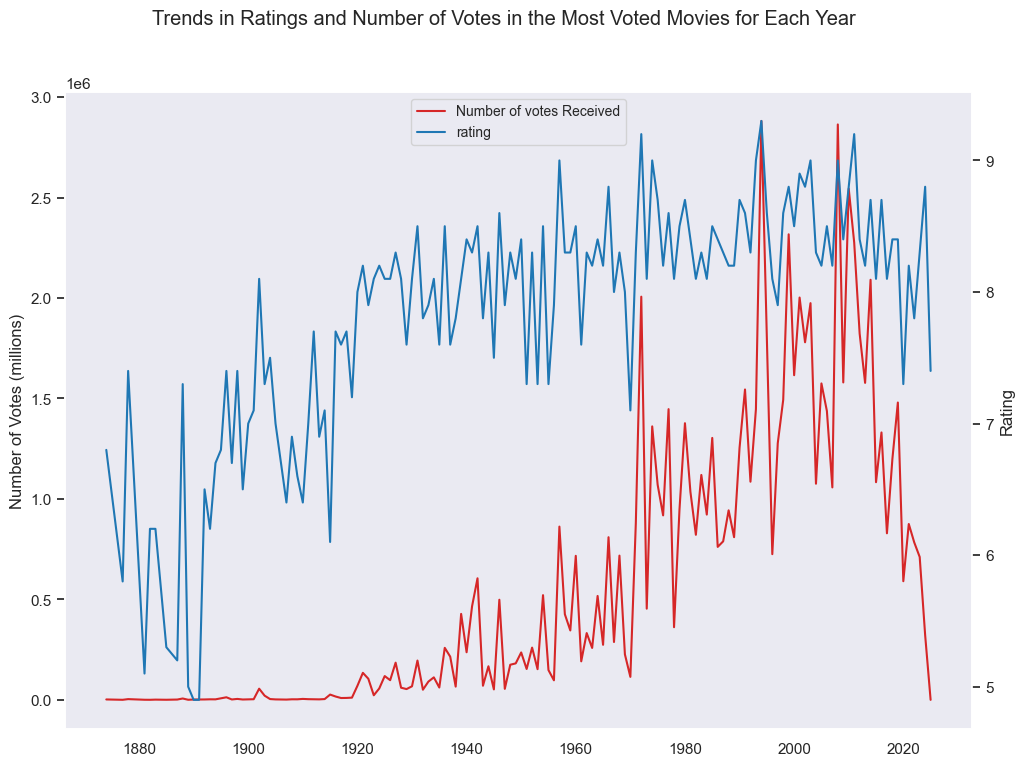

In [334]:
sns.set_theme(rc = {'figure.figsize':(11.7,8.27)})
fig,ax1 = plt.subplots()
plt.suptitle("Trends in Ratings and Number of Votes in the Most Voted Movies for Each Year")
ax2 = ax1.twinx()
a, = ax1.plot( result["start_year"],result["num_votes"],color = "tab:red", label = "Number of votes Received")
b, = ax2.plot(result["start_year"], result["rating"], color =  "tab:blue", label = "rating")
ax1.grid(False)
ax2.grid(False)
ax1.set_ylabel("Number of Votes (millions)")
ax2.set_ylabel("Rating")
p  = [a,b]
ax1.legend(p, [p_.get_label() for p_ in p],
                loc = "upper center", fontsize = "small")

As a proxy for trends in block buster films, I have selected the film with the largest amount of votes from each year, and looked at its trends in rating and viewership. Historically, the number of votes for the highest voted movies has increased, until around 2015 where it appears that the trend is decreasing. The rating of the motion picture increaed until about 1930, where it has been mostly static.

### Cinema Genre Analysis:
Now we can analyze movie genres to determine which genre of movie would be the most profitable. As I do not have information on the amount that movies have grossed, I will be using ratings and number of reviews as a proxy for movie success. To begin with I will create a list of all the unique genres present in our dataset

In [335]:
def split_string(string):
    if string:
        return string.split(",")
    else:
        return []
word_list = df["genres"].apply(split_string)
word_list = [word for sublist in word_list for word in sublist]

To look at the list of unique genres, we can create a set object:

In [336]:
unique_genres = set(word_list)
unique_genres

{'Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

In [337]:
genre_counts = Counter(word_list)
genre_counts = pd.DataFrame.from_dict(genre_counts, orient = "index").reset_index()
genre_counts = genre_counts.rename(columns= {"index":"genre", 0:"count"})
genre_counts = genre_counts.sort_values(by = "count", ascending = False)

<function matplotlib.pyplot.show(close=None, block=None)>

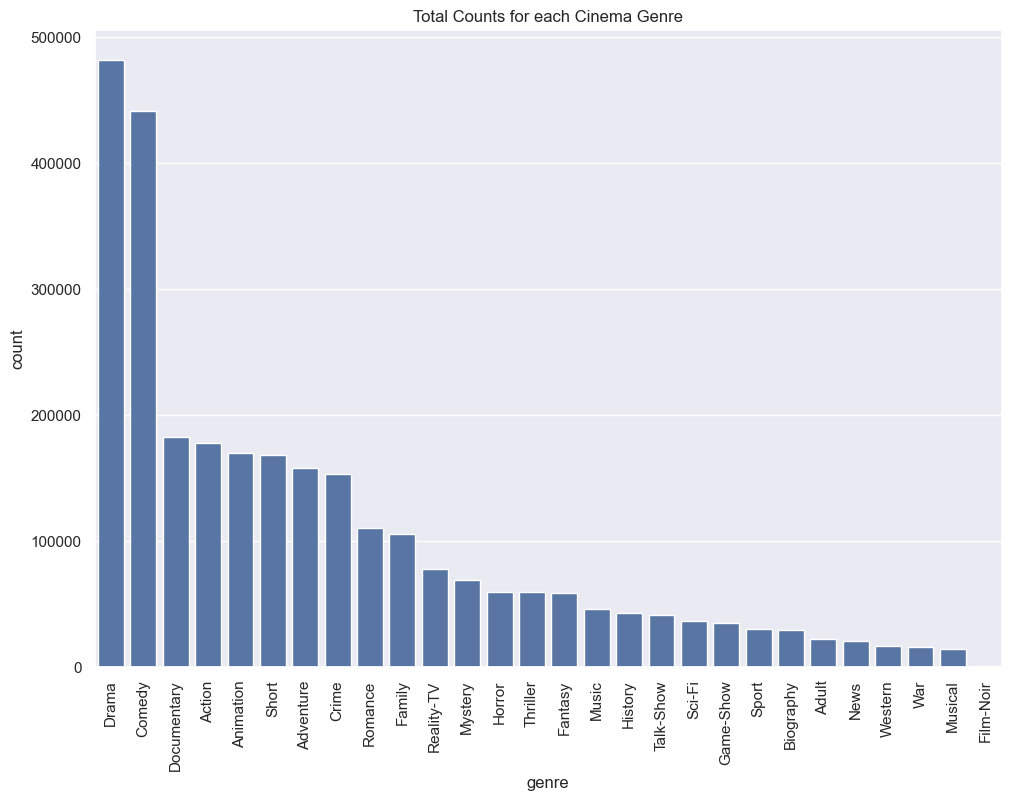

In [338]:

g = sns.barplot(genre_counts, x = "genre",  y= "count")
plt.title("Total Counts for each Cinema Genre")
plt.xticks(rotation = 90)
plt.show

The most common genres by a large margin are drama and comedies. 

For easier analysis and grouping of genres, we will create a column with the genres as a list:

In [339]:
df["genre_list"] = df["genres"].apply(split_string)


In [340]:
genre_dict = {}
for genre in unique_genres:
    temp_dict = {}
    temp = df[df["genre_list"].apply(lambda x: genre in x)]
    
    temp_dict["rating_avg"] = temp["rating"].mean()
    temp_dict["votes_avg"] = temp["num_votes"].mean()
    temp_dict["run_time_avg"] = temp["run_time"].mean()
    

    temp_dict["rating_max"] = temp["rating"].max()
    temp_dict["voting_max"] = temp["num_votes"].max()
    temp_dict["run_time_max"] = temp["run_time"].max()
    
    temp_dict["rating_var"] = temp["rating"].var()
    temp_dict["voting_var"] = temp["num_votes"].var()
    temp_dict["run_time_var"] = temp["run_time"].var()
    
    temp_dict["rating_std"] = temp["rating"].std()
    temp_dict["voting_std"] = temp["num_votes"].std()
    temp_dict["run_time_std"] = temp["run_time"].std()

    temp_dict["rating_med"] = temp["rating"].median()
    temp_dict["voting_med"] = temp["num_votes"].median()
    temp_dict["run_time_med"] = temp["run_time"].median()

    temp_dict["rating_quant1"] = temp["rating"].quantile(0.25)
    temp_dict["voting_quant1"] = temp["num_votes"].quantile(0.25)
    temp_dict["run_time_quant1"] = temp["run_time"].quantile(0.25)

    temp_dict["rating_quant3"] = temp["rating"].quantile(0.75)
    temp_dict["voting_quant3"] = temp["num_votes"].quantile(0.75)
    temp_dict["run_time_quant3"] = temp["run_time"].quantile(0.75)
    
    genre_dict[genre] = temp_dict


In [341]:
genre_df =  pd.DataFrame.from_dict(genre_dict, orient = "index")
genre_df.reset_index(inplace = True)
genre_df = genre_df.rename(columns= {"index":"genre"})

We can display our summary statistics for each genre:

In [342]:
genre_df

,genre,rating_avg,votes_avg,run_time_avg,rating_max,voting_max,run_time_max,rating_var,voting_var,run_time_var,...,run_time_std,rating_med,voting_med,run_time_med,rating_quant1,voting_quant1,run_time_quant1,rating_quant3,voting_quant3,run_time_quant3
0,News,6.794360,63.191597,44.575493,10.0,95584,2520.0,2.693503,9.085956e+05,2268.126666,...,47.624853,7.1,18.0,30.0,6.1,11.0,24.0,7.8,28.00,60.0
1,Game-Show,7.037836,66.754142,48.901462,10.0,46327,2252.0,1.665691,2.911763e+05,920.848385,...,30.345484,7.2,17.0,43.0,6.4,9.0,39.0,7.9,33.00,59.0
2,Short,6.834706,61.158795,14.208187,10.0,53712,338.0,2.145664,2.284726e+05,90.784696,...,9.528100,6.9,15.0,12.0,6.0,9.0,7.0,7.8,32.00,20.0
3,Comedy,6.987216,1012.126633,46.266925,10.0,1577706,3720.0,1.811599,1.965381e+08,1551.541203,...,39.389608,7.2,29.0,30.0,6.3,12.0,22.0,7.9,119.00,77.0
4,Action,7.019099,2676.803939,53.458465,10.0,2863863,2925.0,1.958002,1.031973e+09,1917.283473,...,43.786796,7.3,51.0,43.0,6.3,16.0,23.0,8.0,268.00,84.0
5,History,7.340675,957.330329,70.431094,10.0,1447035,3825.0,1.337910,2.083858e+08,4032.036885,...,63.498322,7.5,28.0,57.0,6.8,11.0,44.0,8.1,104.00,90.0
6,Crime,7.130885,1933.594453,61.149593,10.0,2863863,3720.0,1.339013,6.633518e+08,1343.089596,...,36.648187,7.3,48.0,50.0,6.5,14.0,43.0,7.9,246.00,85.0
7,Talk-Show,6.812746,63.129469,43.178661,10.0,126457,11541.0,2.720726,1.030716e+06,8209.413704,...,90.605815,7.0,17.0,41.0,6.0,11.0,27.0,7.8,27.00,55.0
8,Family,7.084566,628.708421,40.248618,10.0,1197584,3000.0,1.665890,1.290918e+08,1399.917360,...,37.415470,7.2,26.0,28.0,6.4,12.0,22.0,7.9,88.00,53.0
9,Mystery,7.108964,2401.384092,59.986065,10.0,1793969,930.0,1.526366,6.452314e+08,1114.422632,...,33.382969,7.3,83.0,50.0,6.5,21.0,43.0,7.9,379.00,85.0


In [343]:
genre_df[["genre","rating_avg"]].sort_values(by = "rating_avg", ascending = False).head()

,genre,rating_avg
5,History,7.340675
24,Documentary,7.241082
20,Biography,7.190804
6,Crime,7.130885
23,Animation,7.126333


In [344]:
genre_df[["genre","rating_med"]].sort_values(by = "rating_med", ascending = False).head()

,genre,rating_med
5,History,7.5
24,Documentary,7.4
9,Mystery,7.3
6,Crime,7.3
20,Biography,7.3


On average, the highest rated motion picture will be those that have a history genre, followed by a genre and biography. Now we can look at the average ratings recieved for a genre:

In [345]:
genre_df[["genre","votes_avg"]].sort_values(by = "votes_avg", ascending = False).head(15)

,genre,votes_avg
27,Film-Noir,4453.778912
12,Sci-Fi,4436.858997
15,Thriller,3650.359833
20,Biography,2770.189967
4,Action,2676.803939
19,Adventure,2411.058856
9,Mystery,2401.384092
22,Horror,2264.276881
21,Fantasy,2250.768412
6,Crime,1933.594453


Film-Noir, Sci-Fi, and thrillers are the most likely to have a high number of votes. This could be a proxy for the amount of people that will watch the genres. Seeing film noir as the most average votes is quite surprising though. If we look back at our bar plot of the counts of each genre, we can see that film-noir doesn't have enough votes to even show a bar compared to the rest. We should disregard film noir because of this.

In [346]:
genre_df[["genre","voting_med"]].sort_values(by = "voting_med", ascending = False).head(15)

,genre,voting_med
27,Film-Noir,910.5
9,Mystery,83.0
15,Thriller,75.0
22,Horror,52.0
4,Action,51.0
13,Western,49.0
6,Crime,48.0
17,Romance,43.0
12,Sci-Fi,42.0
19,Adventure,41.0


In [347]:
bxpstats_rating = []
for i in range(len(genre_df)):
    temp = {}
    temp["whishi"] = genre_df["rating_med"][i] + genre_df["rating_std"][i]
    temp["whislo"] = genre_df["rating_med"][i] - genre_df["rating_std"][i]
    temp["fliers"] = []
    temp["q1"] = genre_df["rating_quant1"][i]
    temp["med"] = genre_df["rating_med"][i]
    temp["q3"] = genre_df["rating_quant3"][i]
    bxpstats_rating.append(temp)

<Axes: title={'center': 'Box and Whisker plot of Cinema Ratings'}>

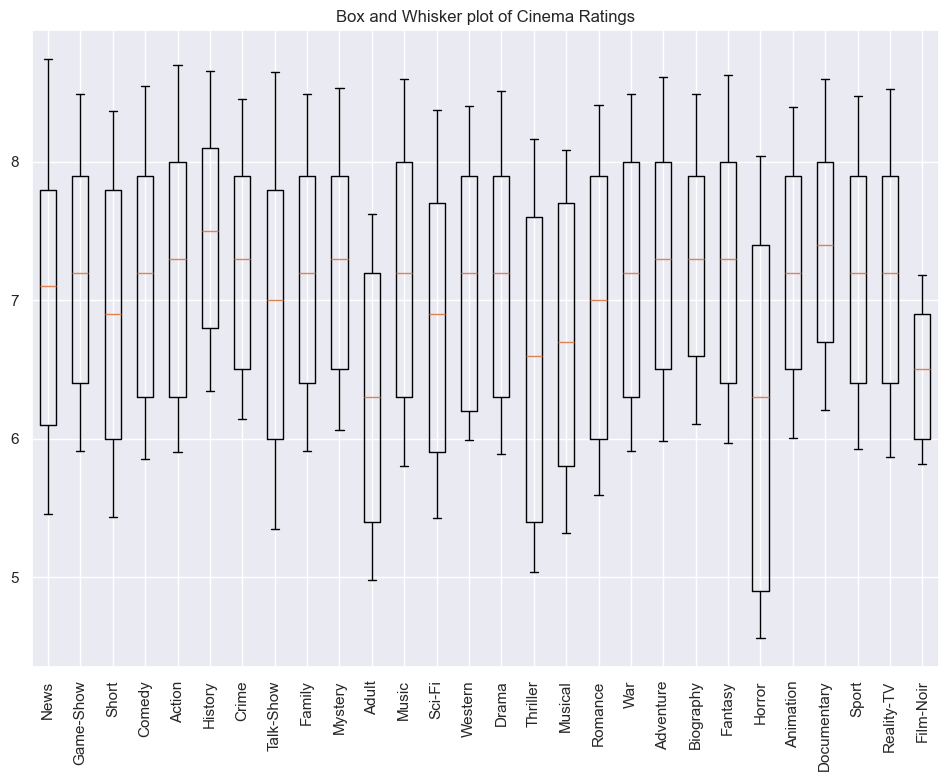

In [348]:
ax=  plt.subplot()
ax.bxp(bxpstats_rating)
ax.set_xticklabels(genre_df['genre'])
plt.title("Box and Whisker plot of Cinema Ratings")
plt.xticks(rotation = 90)
ax

Horror movies have the widest distribution of ratings by a large margin. This would make sense, as they tend to be a seasonal production, that relies on some sort of gimmick to draw people to watch it.

In [349]:
bxpstats_run_time = []
for i in range(len(genre_df)):
    temp = {}
    temp["whishi"] = genre_df["run_time_med"][i] + genre_df["run_time_std"][i]
    temp["whislo"] = genre_df["run_time_med"][i] - genre_df["run_time_std"][i]
    temp["fliers"] = []
    temp["q1"] = genre_df["run_time_quant1"][i]
    temp["med"] = genre_df["run_time_med"][i]
    temp["q3"] = genre_df["run_time_quant3"][i]
    bxpstats_run_time.append(temp)

<Axes: title={'center': 'Box and Whisker plot of Motion Picture Run Times'}>

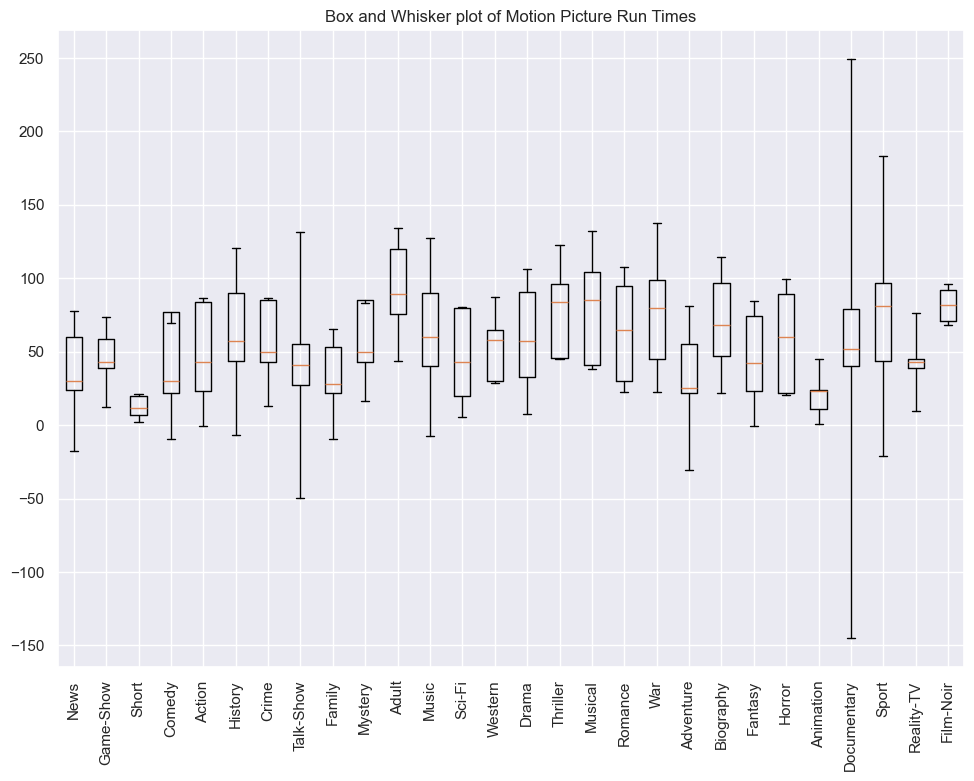

In [350]:
ax=  plt.subplot()
ax.bxp(bxpstats_run_time)
ax.set_xticklabels(genre_df['genre'])
plt.xticks(rotation = 90)
plt.title("Box and Whisker plot of Motion Picture Run Times")
ax

Movies/shows tend to have a median around the 50 minute mark, with varying quartile ranges. The documentaries contain the most extreme values for their interquartile lengths.

Another interesting thing to look at is the type of motion picture that is being produced. We can generate a list of this:

In [351]:
unique_types =df["type"].unique()
unique_types = list(unique_types)
unique_types

['short',
 'movie',
 'tvShort',
 'tvMovie',
 'tvSeries',
 'tvEpisode',
 'tvMiniSeries',
 'tvSpecial',
 'video',
 'videoGame']

It seems as though IMDB categorizes types of motion pictures based on their length and whether they are a movie or television show

In [352]:
type_dict = {}
for types in unique_types:
    temp_dict = {}
    temp = df[df["type"] == types]
    
    temp_dict["rating_avg"] = temp["rating"].mean()
    temp_dict["votes_avg"] = temp["num_votes"].mean()
    temp_dict["run_time_avg"] = temp["run_time"].mean()
    
    temp_dict["type _max"] = temp["rating"].max()
    temp_dict["voting_max"] = temp["num_votes"].max()
    temp_dict["run_time_max"] = temp["run_time"].max()
    
    temp_dict["rating_var"] = temp["rating"].var()
    temp_dict["voting_var"] = temp["num_votes"].var()
    temp_dict["run_time_var"] = temp["run_time"].var()
    
    temp_dict["rating_std"] = temp["rating"].std()
    temp_dict["voting_std"] = temp["num_votes"].std()
    temp_dict["run_time_std"] = temp["run_time"].std()

    temp_dict["rating_med"] = temp["rating"].median()
    temp_dict["voting_med"] = temp["num_votes"].median()
    temp_dict["run_time_med"] = temp["run_time"].median()

    temp_dict["rating_quant1"] = temp["rating"].quantile(0.25)
    temp_dict["voting_quant1"] = temp["num_votes"].quantile(0.25)
    temp_dict["run_time_quant1"] = temp["run_time"].quantile(0.25)

    temp_dict["rating_quant3"] = temp["rating"].quantile(0.75)
    temp_dict["voting_quant3"] = temp["num_votes"].quantile(0.75)
    temp_dict["run_time_quant3"] = temp["run_time"].quantile(0.75)
    
    type_dict[types] = temp_dict


In [353]:
type_df =  pd.DataFrame.from_dict(type_dict, orient = "index")
type_df.reset_index(inplace = True)
type_df = type_df.rename(columns= {"index":"type"})

In [354]:
bxpstats_rating = []
for i in range(len(type_df)):
    temp = {}
    temp["whishi"] = type_df["rating_med"][i] + type_df["rating_std"][i]
    temp["whislo"] = type_df["rating_med"][i] - type_df["rating_std"][i]
    temp["fliers"] = []
    temp["q1"] = type_df["rating_quant1"][i]
    temp["med"] = type_df["rating_med"][i]
    temp["q3"] = type_df["rating_quant3"][i]
    bxpstats_rating.append(temp)

<Axes: title={'center': 'Box and Whisker plot of Motion Picture Type Ratings'}>

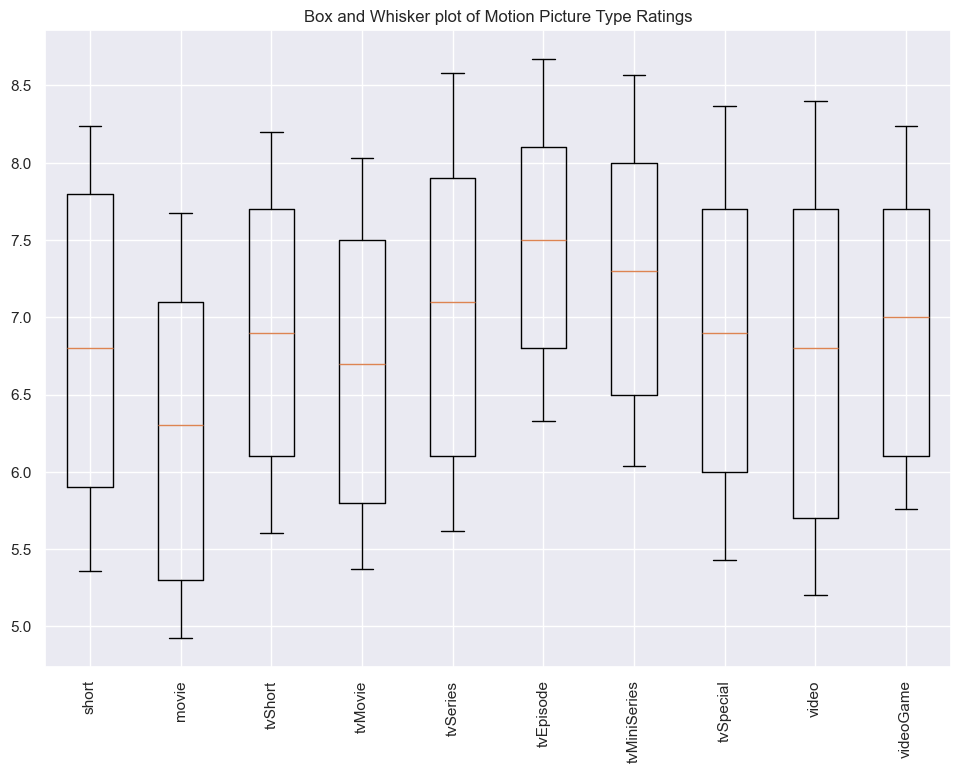

In [355]:
ax=  plt.subplot()
ax.bxp(bxpstats_rating)
ax.set_xticklabels(type_df['type'])
plt.xticks(rotation = 90)
plt.title("Box and Whisker plot of Motion Picture Type Ratings")
ax

In [356]:
bxpstats_run_time = []
for i in range(len(type_df)):
    temp = {}
    temp["whishi"] = type_df["run_time_med"][i] + type_df["run_time_std"][i]
    temp["whislo"] = type_df["run_time_med"][i] - type_df["run_time_std"][i]
    temp["fliers"] = []
    temp["q1"] = type_df["run_time_quant1"][i]
    temp["med"] = type_df["run_time_med"][i]
    temp["q3"] = type_df["run_time_quant3"][i]
    bxpstats_run_time.append(temp)

<Axes: title={'center': 'Box and Whisker plot of Motion Picture Type Run Times'}>

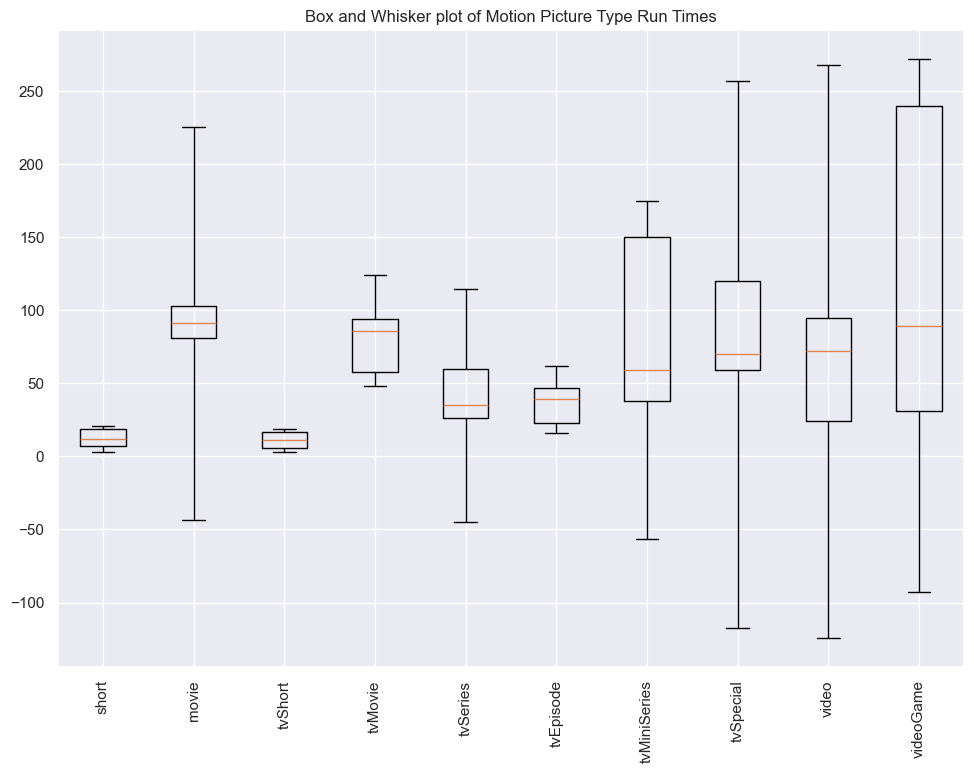

In [357]:
ax=  plt.subplot()
ax.bxp(bxpstats_run_time)
ax.set_xticklabels(type_df['type'])
plt.xticks(rotation = 90)
plt.title("Box and Whisker plot of Motion Picture Type Run Times")
ax

### Actor Analysis:

In [358]:
df2

,nameID,name,profession,movie_id
0,nm0000001,Fred Astaire,"actor,miscellaneous,producer",tt0072308
1,nm0000002,Lauren Bacall,"actress,soundtrack,archive_footage",tt0037382
2,nm0000003,Brigitte Bardot,"actress,music_department,producer",tt0057345
3,nm0000004,John Belushi,"actor,writer,music_department",tt0072562
4,nm0000005,Ingmar Bergman,"writer,director,actor",tt0050986
...,...,...,...,...
23508649,nm9993694,"actor,director,writer",Chinmay Mishra,tt9083282
23508650,nm9993703,actor,James Craigmyle,tt6225166
23508651,nm9993708,"producer,director,writer",Eli Bevins,tt11772858
23508652,nm9993709,"producer,director,writer",Lu Bevins,tt11697102


In [359]:
df2_filtered = df2[df2["profession"].str.contains("actor|actress", case= False, na =False)]
actors = pd.merge(df2_filtered,df[["titleID", "type","primary_title","genre_list","rating","num_votes"]], left_on = "movie_id", right_on = "titleID" )

In [360]:
actors.head()

,nameID,name,profession,movie_id,titleID,type,primary_title,genre_list,rating,num_votes
0,nm0000001,Fred Astaire,"actor,miscellaneous,producer",tt0072308,tt0072308,movie,The Towering Inferno,"[Action, Drama, Thriller]",7.0,48116
1,nm0000002,Lauren Bacall,"actress,soundtrack,archive_footage",tt0037382,tt0037382,movie,To Have and Have Not,"[Adventure, Comedy, Film-Noir]",7.8,37943
2,nm0000003,Brigitte Bardot,"actress,music_department,producer",tt0057345,tt0057345,movie,Contempt,"[Drama, Romance]",7.5,35965
3,nm0000004,John Belushi,"actor,writer,music_department",tt0072562,tt0072562,tvSeries,Saturday Night Live,"[Comedy, Music]",8.0,52580
4,nm0000005,Ingmar Bergman,"writer,director,actor",tt0050986,tt0050986,movie,Wild Strawberries,"[Drama, Romance]",8.1,114735


In [361]:
grouped_actors = actors[["nameID","name","rating","num_votes"]].groupby(by = ["nameID", "name"]).agg({"rating": "mean" ,"num_votes": "mean"}).reset_index()

In [363]:
grouped_actors

,nameID,name,rating,num_votes
0,nm0000001,Fred Astaire,7.05,31250.0
1,nm0000002,Lauren Bacall,7.20,30135.5
2,nm0000003,Brigitte Bardot,6.50,18346.5
3,nm0000004,John Belushi,7.95,133343.0
4,nm0000005,Ingmar Bergman,8.10,156399.5
...,...,...,...,...
3085991,nm9993656,Jerzy Ciurlok,5.40,153.0
3085992,nm9993693,Apsara Rani,4.85,947.5
3085993,nm9993694,Chinmay Mishra,8.80,36.0
3085994,nm9993700,Sexy Angel,5.10,13.0


Unfortunately it is difficult to gather much information from our acting dataframe. This is because the highest rated actors are often people that had only 1 appearance as an extra in a show/movie that happened to recieve good reviews. For example:

In [365]:
grouped_actors[grouped_actors["num_votes"]> 100000].sort_values(by = "rating", ascending = False).head(10)

,nameID,name,rating,num_votes
813365,nm1193643,Samantha Anastasiou,9.5,2127233.0
177236,nm0366479,Phillip Hart,9.5,2127233.0
1943311,nm3613578,Erin Miller-Gibbs,9.5,2127233.0
1768171,nm2944532,Jesus Ramirez,9.5,2127233.0
2430648,nm5901211,Millard Drexler,9.5,2127233.0
1768189,nm2944601,Jason Byrd,9.5,2127233.0
2428150,nm5887567,Victoria Lease,9.5,2127233.0
2159695,nm4576082,Veronica Jaquez,9.5,2127233.0
2159665,nm4575861,Maria L. Pardo,9.5,2127233.0
1967525,nm3714123,Martiniano Berrelleza Alvarado,9.5,2127233.0


Even when we filter by actors with over 100000 average votes, all of the top 10 actors have the same rating and the same amount of votes, because they appeared in the same production. We can determine the production that they are in by looking at their ungrouped data: 

In [366]:
actors[actors["nameID"] == "nm1193643"]

,nameID,name,profession,movie_id,titleID,type,primary_title,genre_list,rating,num_votes
779289,nm1193643,Samantha Anastasiou,"costume_department,costume_designer,actress",tt0903747,tt0903747,tvSeries,Breaking Bad,"[Crime, Drama, Thriller]",9.5,2127233


Clearly something would need to be done to improve the analysis on this data. To improve it, another column could be added that specifies if an actors role was a lead in the production, or the grouping could be filtered for those that have appeared in more than one production, as this would make it less likely for them to have such a high rating as an extra.

In [ ]:
mydb.close()

## Conclusions

* The most popular motion picture genres to produce are dramas and comedies by a significant margin
* The invention of smartphones has lowered the bar for motion picture production, causing an influx of pieces and as a result, lowering the average amount of votes on any one motion picture
* The highest rated genres on average are documentaries and historical pieces
* The most volatile genre are horror films, which eigher become cult classics or forgotten flops
* The length of cinema over time has increased significantly, due to major culture shifts that happened in the 1920s
* Tv shows are more likely to be highly rated than movies 
* The reviewing habits of consumers over time have changed to be more generous
* In order to analyze an actors' influence in cinema, more data will need to be gathered